In [1]:
!pip install fastai --upgrade
!pip install timm wwf

Requirement already up-to-date: fastai in /usr/local/lib/python3.6/dist-packages (2.2.5)


In [2]:
!wget https://www.dropbox.com/s/cb3g53z4pbtaqvl/erm.zip?dl=1 -O erm.zip

--2021-02-04 15:20:35--  https://www.dropbox.com/s/cb3g53z4pbtaqvl/erm.zip?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.6.18, 2620:100:6019:18::a27d:412
Connecting to www.dropbox.com (www.dropbox.com)|162.125.6.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/dl/cb3g53z4pbtaqvl/erm.zip [following]
--2021-02-04 15:20:36--  https://www.dropbox.com/s/dl/cb3g53z4pbtaqvl/erm.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc3536608b89ba2a431cca3baa12.dl.dropboxusercontent.com/cd/0/get/BIQaymfSfF763WLwJxxkVc_PgC0A9OqGBOawf2Jx1uoBhCu3vDAqxi7MH4Gywkmn4XlQXEoBvlzDqisdwgqEScLV_rZh2tmICnS42estbNjeiSCFc5Od7lsiIv8HKDW_sLA/file?dl=1# [following]
--2021-02-04 15:20:36--  https://uc3536608b89ba2a431cca3baa12.dl.dropboxusercontent.com/cd/0/get/BIQaymfSfF763WLwJxxkVc_PgC0A9OqGBOawf2Jx1uoBhCu3vDAqxi7MH4Gywkmn4XlQXEoBvlzDqisdwgqEScLV_rZh2tmICnS42estbNjeiSCFc5Od7lsiIv8H

In [6]:
!unzip erm.zip

Archive:  erm.zip
   creating: dataset/
   creating: dataset/test/
   creating: dataset/test/no/
  inflating: dataset/test/no/anonymized_1421704.jpg  
  inflating: dataset/test/no/anonymized_336537.jpg  
  inflating: dataset/test/no/anonymized_569526.jpg  
  inflating: dataset/test/no/anonymized_196860.jpg  
  inflating: dataset/test/no/anonymized_920184.jpg  
  inflating: dataset/test/no/anonymized_1348815.jpg  
  inflating: dataset/test/no/anonymized_225304.jpg  
  inflating: dataset/test/no/anonymized_816099.jpg  
  inflating: dataset/test/no/anonymized_260226.jpg  
  inflating: dataset/test/no/anonymized_1619231.jpg  
  inflating: dataset/test/no/anonymized_1314755.jpg  
  inflating: dataset/test/no/anonymized_1182585.jpg  
  inflating: dataset/test/no/anonymized_656024.jpg  
  inflating: dataset/test/no/anonymized_198917.jpg  
  inflating: dataset/test/no/anonymized_246204.jpg  
  inflating: dataset/test/no/anonymized_324557.jpg  
  inflating: dataset/test/no/anonymized_492637.jpg

In [7]:
from fastai.vision.all import *
import fastai
from wwf.vision.timm import *

In [8]:
path = Path('dataset/')
trainPath = path/'train'
testPath = path/'test'

In [9]:
def getDataBlock(presize=512,size=256):
    return DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=RandomSplitter(valid_pct=0.2,seed=42),
                 get_y=parent_label,
                 item_tfms = Resize(presize),
                 batch_tfms=[*aug_transforms(size=size, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])

In [10]:
db512 = getDataBlock()
dls512 = db512.dataloaders(trainPath,bs=64)

In [11]:
from fastai.vision.all import *
callbacks = [
    ShowGraphCallback(),
    EarlyStoppingCallback(patience=3),
    SaveModelCallback(fname='resnest34')
]

In [12]:
import timm
timm.list_models('*resnet34*')

['gluon_resnet34_v1b',
 'legacy_seresnet34',
 'resnet34',
 'resnet34d',
 'seresnet34',
 'skresnet34',
 'tv_resnet34']

In [13]:
learn = timm_learner(dls512, 'resnet34d',cbs = callbacks,metrics=[accuracy,Precision(),Recall()]).to_fp16()

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/resnet34d_ra2-f8dcfcaf.pth" to /root/.cache/torch/hub/checkpoints/resnet34d_ra2-f8dcfcaf.pth


SuggestedLRs(lr_min=0.0003019951749593019, lr_steep=6.309573450380412e-07)

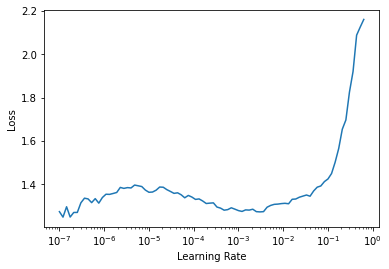

In [14]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.351845,0.965830,0.489297,0.481308,0.647799,00:24


Better model found at epoch 0 with valid_loss value: 0.9658300876617432.


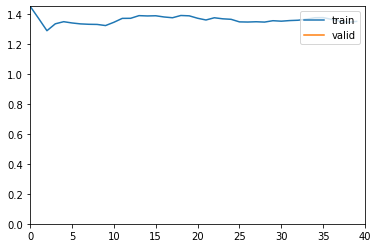

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.340841,1.010433,0.477064,0.473094,0.663522,00:25
1,1.337268,0.993827,0.483180,0.477169,0.657233,00:25
2,1.308442,0.996146,0.481651,0.475973,0.654088,00:26
3,1.325669,0.987917,0.483180,0.476077,0.625786,00:26
4,1.298568,0.976294,0.489297,0.481221,0.644654,00:25
5,1.320632,0.969077,0.492355,0.483254,0.635220,00:25
6,1.330367,0.969715,0.487768,0.480000,0.641509,00:25
7,1.299717,0.964401,0.486239,0.479070,0.647799,00:25
8,1.279287,0.968430,0.477064,0.471831,0.632075,00:25
9,1.311143,0.983907,0.495413,0.486239,0.666667,00:25


Better model found at epoch 0 with valid_loss value: 1.0104330778121948.


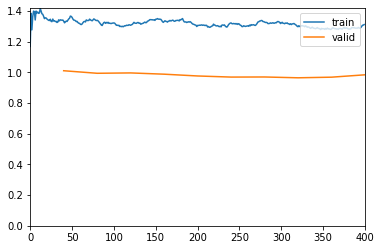

Better model found at epoch 1 with valid_loss value: 0.993826687335968.
Better model found at epoch 3 with valid_loss value: 0.9879170060157776.
Better model found at epoch 4 with valid_loss value: 0.9762937426567078.
Better model found at epoch 5 with valid_loss value: 0.969076931476593.
Better model found at epoch 7 with valid_loss value: 0.9644006490707397.


In [15]:
learn.fine_tune(10,base_lr=1e-5)

In [16]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(512),
                 batch_tfms=[*aug_transforms(size=256, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])
dlsTest = dbTest.dataloaders(path,bs=32)

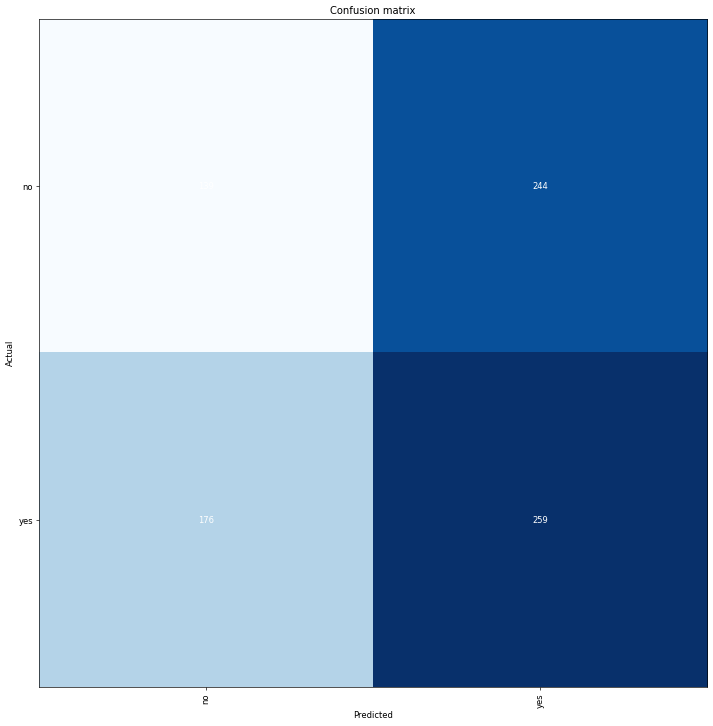

In [17]:
learn.dls = dlsTest
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12),dpi=60)

In [18]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 0.48655256628990173.


(#4) [1.007116675376892,0.48655256628990173,0.5149105367793241,0.5954022988505747]

In [19]:
learn.export(fname='resnet50.pkl')